### **DATA DESCRIPTION**

In [21]:

# !pip3 install shap
import shap
import numpy as np
import pandas as pd
from math import exp
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import plotly.graph_objects as go
pd.set_option('display.max_rows', None)

### **DATA DESCRIPTION**

#### **SUMMARY**
##### DOWNLOAD HERE https://raw.githubusercontent.com/yazid-mekhtoub/notes/7fcd1004be1d6e923a26e4905c409157ffc8de36/titanic.csv
This is a classic dataset used in many data mining tutorials and demos -- perfect for getting started with exploratory analysis and building binary classification models to predict survival.


#### **Features**
* embarked - Port of Embarkation ({"Cherbourg": 1, "Queenstown": 2 , "Southampton": 3, "Unknown": 4})
* cabin - Cabin ({"A" : 1, "B" : 2, "C": 3, "D" : 4, "E": 5, "F" : 6, "G" : 7, "T": 8, "Unknown":9})
* class - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
* nsiblings - Number of Siblings/Spouses Aboard
* nparents - Number of Parents/Children Aboard
* age - Age
* fare - Passenger Fare
* isfemale - Sex (female = 1, male = 0)
* survival - Survival (0 = No; 1 = Yes)

In [26]:
df = pd.read_csv('https://raw.githubusercontent.com/yazid-mekhtoub/notes/main/titanic.csv')
df.to_csv('titanic.csv', index=False)
df.index.name='_key'
df.head()

,Embarked,Class,Age,Fare,isFemale,Y
_key,,,,,,
0,3,3,22.0,7.2500,0,0
1,1,1,38.0,71.2833,1,1
2,3,3,26.0,7.9250,1,1
3,3,1,35.0,53.1000,1,1
4,3,3,35.0,8.0500,0,0


Accuracy on test data: 84.75%
AUC on test data 0.88


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


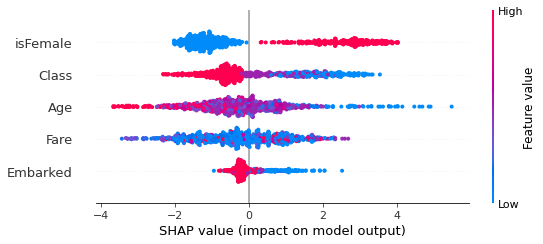

In [27]:
X = df[df.columns[0:-1]]
features = list(X.columns)
Y = df[df.columns[-1]]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=0)
model = XGBClassifier()
model.fit(X_train, y_train)
accuracy = accuracy_score(y_test, model.predict(X_test))
print("Accuracy on test data: %.2f%%" % (accuracy * 100.0))
auc= roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print("AUC on test data", round(auc,2))
explainer = shap.TreeExplainer(model)
baseValue = explainer.expected_value[0]
_shap = explainer.shap_values(X)
shap.summary_plot(_shap, X, max_display=10,show=False)



In [30]:
_shap = pd.DataFrame(_shap, columns = X.columns, index=df.index)
_shap['baseValue'] = baseValue
_shap['sumShap'] = _shap[_shap.columns].sum(axis=1)
_shap['Y'] = Y
_shap['P']=_shap.apply(lambda x: 1/(1+ exp(-x['sumShap'])), axis=1)

_shap['R'] = _shap['Y'] -_shap['P']
df['P'] = _shap['P']
df['R'] = _shap['R']
_shap.head()

,Embarked,Class,Age,Fare,isFemale,baseValue,sumShap,Y,P,R
_key,,,,,,,,,,
0,-0.280397,-0.481697,-0.239425,-0.529779,-1.583931,-0.610898,-3.726127,0,0.023519,-0.023519
1,1.187934,2.333913,0.060382,0.990020,3.302827,-0.610898,7.264178,1,0.999300,0.000700
2,-0.436465,-0.892553,0.582206,0.889678,1.843027,-0.610898,1.374995,1,0.798186,0.201814
3,-0.291159,2.798014,0.737292,0.533108,3.014283,-0.610898,6.180641,1,0.997935,0.002065
4,-0.155388,-0.843223,-0.988544,-0.012749,-0.657566,-0.610898,-3.268369,0,0.036672,-0.036672


In [31]:
df.head()

,Embarked,Class,Age,Fare,isFemale,Y,R,P
_key,,,,,,,,
0,3,3,22.0,7.2500,0,0,-0.023519,0.023519
1,1,1,38.0,71.2833,1,1,0.000700,0.999300
2,3,3,26.0,7.9250,1,1,0.201814,0.798186
3,3,1,35.0,53.1000,1,1,0.002065,0.997935
4,3,3,35.0,8.0500,0,0,-0.036672,0.036672


In [32]:
# A FILTER 
B_filters = {
    "isFemale":"== 1",
    "Embarked": "!= 4"
}

# B FILTER 
A_filters = {
    "isFemale":"== 0",
    "Embarked": "!= 4"
}


In [78]:
def avsb(df, _shap, A_filters, B_filters):

    def make_filter(filters):
        s = ""
        for key, value in filters.items():
            s = s + f"`{key}` { value} & "
        s = s[:-3]
        return s
    
    a_f = make_filter(A_filters)
    b_f = make_filter(B_filters)
    
    a_actual, a_residual = float(df.query(a_f)[['Y']].mean()), float(df.query(a_f)[['R']].mean())
    b_actual, b_residual = float(df.query(b_f)[['Y']].mean()), float(df.query(b_f)[['R']].mean())
    alloc = b_actual - a_actual - b_residual + a_residual

    
    A = _shap.loc[df.query(a_f).index].mean()
    B = _shap.loc[df.query(b_f).index].mean()
    

    df = B.subtract(A).to_frame(name='avg_shap_diff').reset_index()
    df['avg_shap_diff_sum'] = df.avg_shap_diff.sum()
    df = df.rename({'index':'features'}, axis=1)
    df['proportion']= (df['avg_shap_diff']/df['avg_shap_diff_sum']) *   100
    
    df['contribution'] =  df['proportion'] * alloc
    
    df= df[['features', 'contribution']]
    df['measure'] = 'relative'
    df = df.sort_values(by=['contribution'], ascending=False)
    values = df.values.tolist()
    df = df.sort_values(by=['contribution'])
    values.insert(0,   ['A',  a_actual*100,  'absolute'])
    values.append(['A Residuals', - a_residual*100,  'relative'])
    values.append(['B Residuals', b_residual*100, 'relative'])
    values.append(['B',  b_actual*100,  'total'])

    df = pd.DataFrame(values, columns = df.columns)
    df['no_yaxis'] = np.where(df['features'].isin(['A', 'B']), df['contribution']/2, df['contribution'])
    
    return df


d = avsb(df, _shap[features], A_filters, B_filters)
d
  

,features,contribution,measure,no_yaxis
0,A,18.890815,absolute,9.445407
1,isFemale,42.458065,relative,42.458065
2,Class,6.266308,relative,6.266308
3,Age,4.182524,relative,4.182524
4,Fare,3.086865,relative,3.086865
5,Embarked,0.685100,relative,0.685100
6,A Residuals,-0.274741,relative,-0.274741
7,B Residuals,-1.256465,relative,-1.256465
8,B,74.038462,total,37.019231


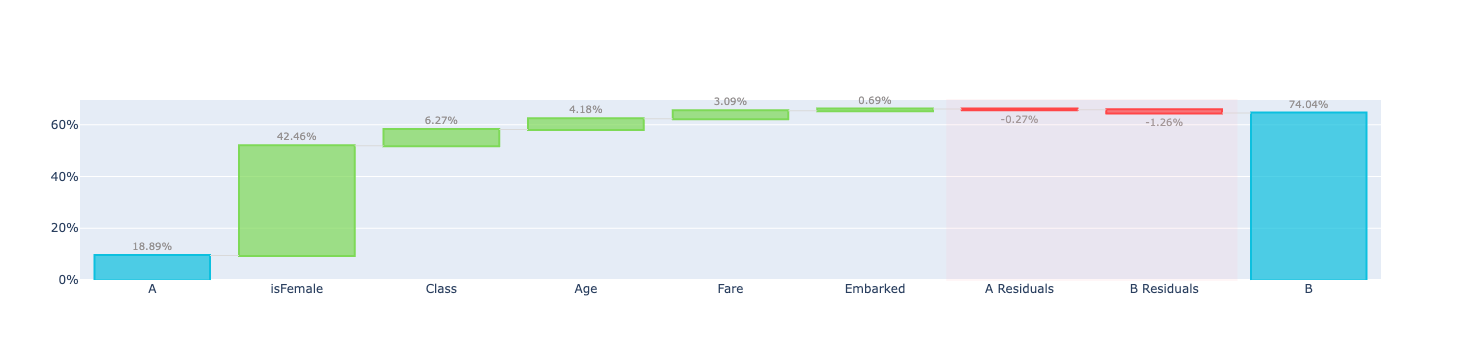

In [79]:


def generate_waterfall(df):
    red = '255, 49, 49'
    green = '126, 217, 87'
    fig  = go.Figure()
    fig.add_trace(go.Waterfall(
        width= [0.8] * len(df),
                x = df['features'], 
                y = df['no_yaxis'],
                measure = df['measure'],
                base = 0,
                cliponaxis= False,
                textfont=dict(
                    family="verdana, arial, sans-serif",
                    size=10,
                    color="rgb(148, 144, 144)"
                ),
                text =  df['contribution'].apply(lambda x: '{0:1.2f}%'.format(x)),
                textposition = 'outside',
                decreasing = {"marker":{"color":f"rgba({red}, 0.7)",  "line":{"color":f"rgba({red}, 1)","width":2}}},
                increasing = {"marker":{"color":f"rgba({green}, 0.7)","line":{"color":f"rgba({green}, 1)", "width":2}}},
                totals     = {"marker":{"color":"rgba(12, 192, 223, 0.7)", "line":{"color":"rgba(12, 192, 223, 1)", "width":2}}},
                connector = {"line":{"color":"rgba(217, 217, 217, 1)", "width":1}},
                ))

    
    end = 0.5 + len(df) -2
    start = 0.5 + len(df) -4
    # fig.update_yaxes(visible=ax_visibale)
    fig.add_vrect(x0=start, x1=end, fillcolor="pink", opacity=0.15 , line_color="pink")
    fig.update_annotations(font=dict( size=14, color="rgb(148, 144, 144)"))
    fig.update_yaxes(ticksuffix = "%")
    return fig
generate_waterfall(d)